# Build Named Entity Recognation Model with BERT

# **Objective**

The objective of this notebook is to be able to build ner  model using BERT for the given dataset .

The main section of this notebook organize as follows:

- Load NER Data from kaggle.
- Select the relevant columns.
- Identify unique entity tagers in the dataset.
- Remove Duplicate Sentences.
- Finetune Bert Model
- Apply the model to a new sentences.
- Conclusion
- Acknowledgements


# Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth',150)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from tqdm import tqdm, trange
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline

# Download the Datasets

In [ ]:
pathdir = "/content/data"

In [ ]:
def download_dataset():
  
  if not os.path.isfile('ner.csv'):

    # Downloading Annotated Corpus for Named Entity Recognition dataset
    !gdown https://drive.google.com/uc?id=13y8JNgL5TQ4x-yufpBOv3QBsEiE051sE

  if not os.path.exists(pathdir):
    # Make a data folder to store the data
    !mkdir data

    !mv /content/ner.csv ./data


In [ ]:
download_dataset()

Downloading...
From: https://drive.google.com/uc?id=13y8JNgL5TQ4x-yufpBOv3QBsEiE051sE
To: /content/ner.csv
100% 157M/157M [00:01<00:00, 78.6MB/s]


# Load Data

In [ ]:
#specify the path to data location

filepath = '/content/data/ner.csv'
data = pd.read_csv(filepath, encoding = "latin1", on_bad_lines='skip')


In [ ]:
#Verify that the data is loaded correctly
data.head()

In [ ]:
#totally the data have 1050795 rows and 25 columns
data.shape

(1050795, 25)

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
data.describe()

,Unnamed: 0,sentence_idx
count,1.050795e+06,1.050794e+06
mean,4.153109e+05,1.898184e+04
std,3.447835e+05,1.576237e+04
min,0.000000e+00,1.000000e+00
25%,1.313490e+05,5.997000e+03
50%,2.626980e+05,1.201700e+04
75%,7.858755e+05,3.592600e+04
max,1.048574e+06,4.795900e+04


# Select the data which contains only Sentence, Word, Pos and tag columns

In [ ]:
ner_data = data[['sentence_idx', 'word', 'pos','tag']]

In [ ]:
ner_data.shape

(1050795, 4)

In [ ]:
ner_data.head()

In [ ]:
ner_data.isnull().sum()

sentence_idx    1
word            1
pos             1
tag             1
dtype: int64

In [ ]:
#drop null value
ner_data = ner_data.dropna()

In [ ]:
# the total number of unique sentence
len(ner_data['sentence_idx'].unique())

35177

In [ ]:
# the total number of unique word
len(ner_data['word'].unique())

30172

In [ ]:
# the total number of unique tag
len(ner_data['tag'].unique())

17

# Remove Duplicated Sentences

In [ ]:
class Build_sentence(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = Build_sentence(ner_data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
tag = [[tag[2] for tag in tags] for tags in getter.sentences]

for ind in range(len(sentences)):
  sent=' '.join(sentences[ind])
  sent = sent.split('.')[0]
  sentences[ind] = sent.split(" ")
  sentences[ind][-1] = sentences[ind][-1].replace('', '.')

In [ ]:
max=0
for i in range(len(sentences)):
  if len(sentences[i]) > max:
    max = len(sentences[i])
print(max)

92


In [ ]:
labels=[]
for ind in range(len(sentences)):
  labels.append(tag[ind][0:len(sentences[ind])])
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(ner_data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'I-tim': 0,
 'B-nat': 1,
 'I-eve': 2,
 'I-org': 3,
 'O': 4,
 'I-nat': 5,
 'B-per': 6,
 'I-gpe': 7,
 'B-gpe': 8,
 'B-tim': 9,
 'B-org': 10,
 'B-eve': 11,
 'I-art': 12,
 'B-art': 13,
 'B-geo': 14,
 'I-geo': 15,
 'I-per': 16,
 'PAD': 17}

# Apply Bert
- Prepare the sentences and labels

In [ ]:
pip install transformers==2.6.0

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.12.1+cu113'

In [ ]:
# Define maximumn sequence length and batch size
MAX_LEN = 95
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
# Now we tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
tokenized_texts[0]

In [ ]:
labels[0]

In [ ]:
# cut and pad the token and label sequences to our desired length
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
# create the mask to ignore the padded elements in the sequences.
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

# Split the datasets
- split the dataset to use 10% to validate the model.

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=42, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.1)

In [ ]:
len(tr_inputs)

31659

In [ ]:
#  convert the dataset to torch tensors.
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
# define the dataloaders. 
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

# Setup the Bert model for finetuning
- BertForTokenClassification class for token-level predictions.
- BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel.

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW
transformers.__version__

'2.6.0'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# pass model parameter to GPU
model.cuda();

In [ ]:
# setup the optimizer and add the parameters it should update
# Add some weight_decay as regularization to the main weight matrices.

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
# add a scheduler to linearly reduce the learning rate throughout the epochs.
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# define evaluation metrics
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score

## Finetune Bert Model

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print("Validation F1-Score: {}".format(f1_score([valid_tags], [pred_tags])))
    print("Precision Score: {}".format(precision_score([valid_tags], [pred_tags])))
    print("Recall Score: {}".format(recall_score([valid_tags], [pred_tags])))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.2906946383491911
Validation loss: 0.19463300237601452
Validation Accuracy: 0.9405639049303611
Validation F1-Score: 0.8250592950028625
Precision Score: 0.8175482197849695


Epoch:  33%|███▎      | 1/3 [08:34<17:08, 514.11s/it]

Recall Score: 0.8327096632181378

Average train loss: 0.16602469648450915
Validation loss: 0.17961870215155862
Validation Accuracy: 0.9446051845517693
Validation F1-Score: 0.8369175136290167
Precision Score: 0.8332878730020185


Epoch:  67%|██████▋   | 2/3 [17:22<08:42, 522.55s/it]

Recall Score: 0.8405789126128109

Average train loss: 0.1257703553998109
Validation loss: 0.1852751062336293
Validation Accuracy: 0.9448277477772962
Validation F1-Score: 0.8381139703873682
Precision Score: 0.8321579689703809


Epoch: 100%|██████████| 3/3 [26:12<00:00, 524.13s/it]

Recall Score: 0.8441558441558441



# Visualize the training loss

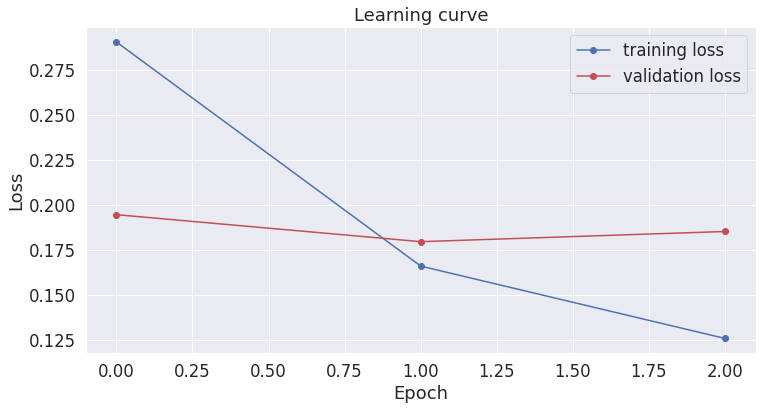

In [ ]:


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Apply the model to a new sentence

In [ ]:
test_sentence = """
Kedir is a student at ForthBrain. 
"""

In [ ]:
# first toknize the sentences
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
# run the sentences through the model
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


B-per	[CLS]
B-per	kedir
O	is
O	a
O	student
O	at
B-org	forthbrain
O	.
O	[SEP]


# Save Model

In [ ]:
model_path = '/content/model'

In [ ]:
torch.save(model.state_dict(), model_path)

# Load Model

In [ ]:
model = BertForTokenClassification()
model.load_state_dict(torch.load(model_path))
model.eval()




## Acknowledgements

- The code for NER model is adapted from this online tutorial [Named Entity Recognation with bert ](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)